## Improving the interpolator

In [220]:
import jax
import jax.numpy as jnp
# from jax import 
import matplotlib.pyplot as plt
from scipy.special import hyp2f1

from jaxinterp2d import interp2d

In [221]:
def get_lam(gamma_s):
    return (11 - 2 * (gamma_s + 5 / 2)) / 3


def get_th_d(gamma_s):
    return (8 + 3 * get_lam(gamma_s)) / 5

In [222]:
def hypgeom_scipy(b, z):
    return hyp2f1(1, b, 1 + b, z)


def get_hypgeom_interp_pos(n_bs=50, n_zs=750):
    bs = jnp.linspace(1.6, 2.0, n_bs)  # gamma_s in [2, 3], gamma_e = 5/2
    log10_abs_zs = jnp.linspace(-8, 7, n_zs)
    zs = -(10 ** log10_abs_zs)
    b_mg, z_mg = jnp.meshgrid(bs, zs, indexing="ij")

    vals_pos = jnp.log10(jnp.array(hypgeom_scipy(b_mg, z_mg)))

    return lambda b, z: 10 ** interp2d(
        b, jnp.log10(-z), bs, log10_abs_zs, vals_pos, jnp.nan
    )


def get_hypgeom_interp_neg(n_bs=100, n_zs=500):
    bs = jnp.linspace(1.6, 2.0, n_bs)  # gamma_s in [2, 3], gamma_e = 5/2
    log10_abs_zs = jnp.concatenate(
        (
            jnp.linspace(-8, -2.5, 20),
            jnp.linspace(-2.5, 1.5, n_zs)[1:-1],
            jnp.linspace(1.5, 7, 20),
        )
    )
    zs = -(10 ** log10_abs_zs)
    b_mg, z_mg = jnp.meshgrid(bs, zs, indexing="ij")

    vals_neg = jnp.log10(1 - hypgeom_scipy(-b_mg[::-1, :], z_mg))

    return lambda b, z: 1 - 10 ** interp2d(
        b, jnp.log10(-z), -bs[::-1], log10_abs_zs, vals_neg, jnp.nan
    )


interp_pos = get_hypgeom_interp_pos()
interp_neg = get_hypgeom_interp_neg()


def restricted_hypgeom(b, z: jnp.ndarray) -> jnp.ndarray:
    # Assumes b is a scalar
    return jax.lax.cond(
        b > 0, lambda z: interp_pos(b, z), lambda z: interp_neg(b, z), z
    )


@jax.jit
def hypgeom_jax(b, z: jnp.ndarray) -> jnp.ndarray:
    return jax.lax.cond(
        b == 1, lambda z: jnp.log(1 - z) / (-z), lambda z: restricted_hypgeom(b, z), z
    )

### Validate

In [207]:
import numpy as np

In [208]:
def test_hypgeom(n=10000):
    bs = np.random.rand(n) * (2 - 1.6) + 1.6
    zs = -(10 ** (np.random.rand(n) * (7 + 8) - 8))
    vals_scipy = jnp.array(hypgeom_scipy(bs, zs))
    vals_jax = jax.vmap(hypgeom_jax, in_axes=(0, 0))(bs, zs)
#     return (vals_scipy - vals_jax) / vals_scipy
    return jnp.allclose(vals_scipy, vals_jax, rtol=1e-4, atol=0)

In [209]:
test_hypgeom()

DeviceArray(True, dtype=bool)

### `b > 0`

Interpolating `b`

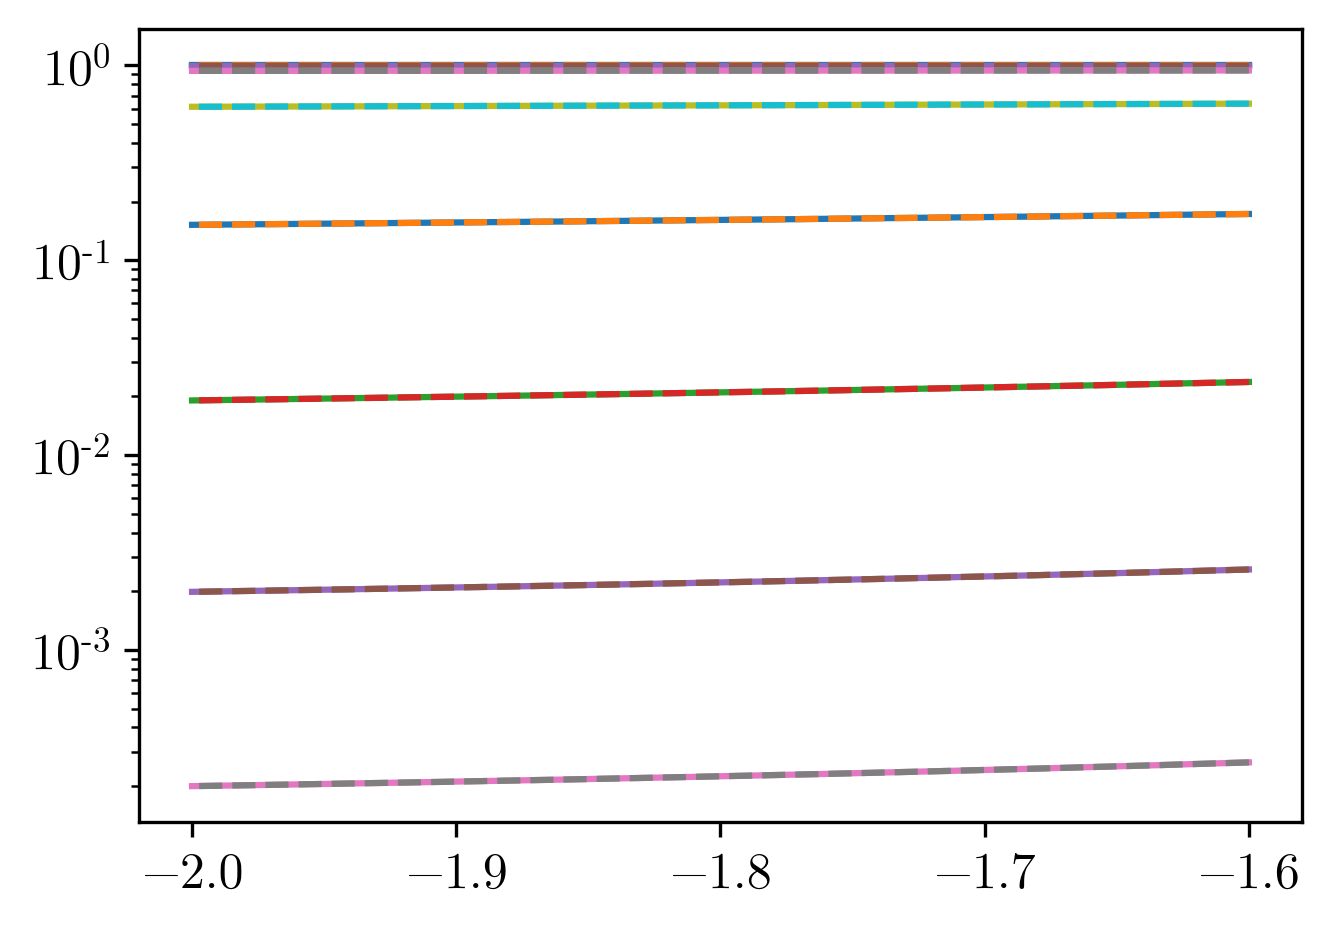

In [210]:
for i, z in enumerate(jnp.geomspace(-1e-4, -1e4, 9)):
    bs = jnp.linspace(1.6, 2.0, 1000)
    vals_scipy = hypgeom_scipy(bs, z)
    vals_jax = jax.vmap(hypgeom_jax, in_axes=(0, None))(bs, z)
    plt.semilogy(-bs, vals_scipy)#, f"C{i}")
    plt.semilogy(-bs, vals_jax, "--")#, f"--C{i+10}")

# plt.ylim(0, 1.5)

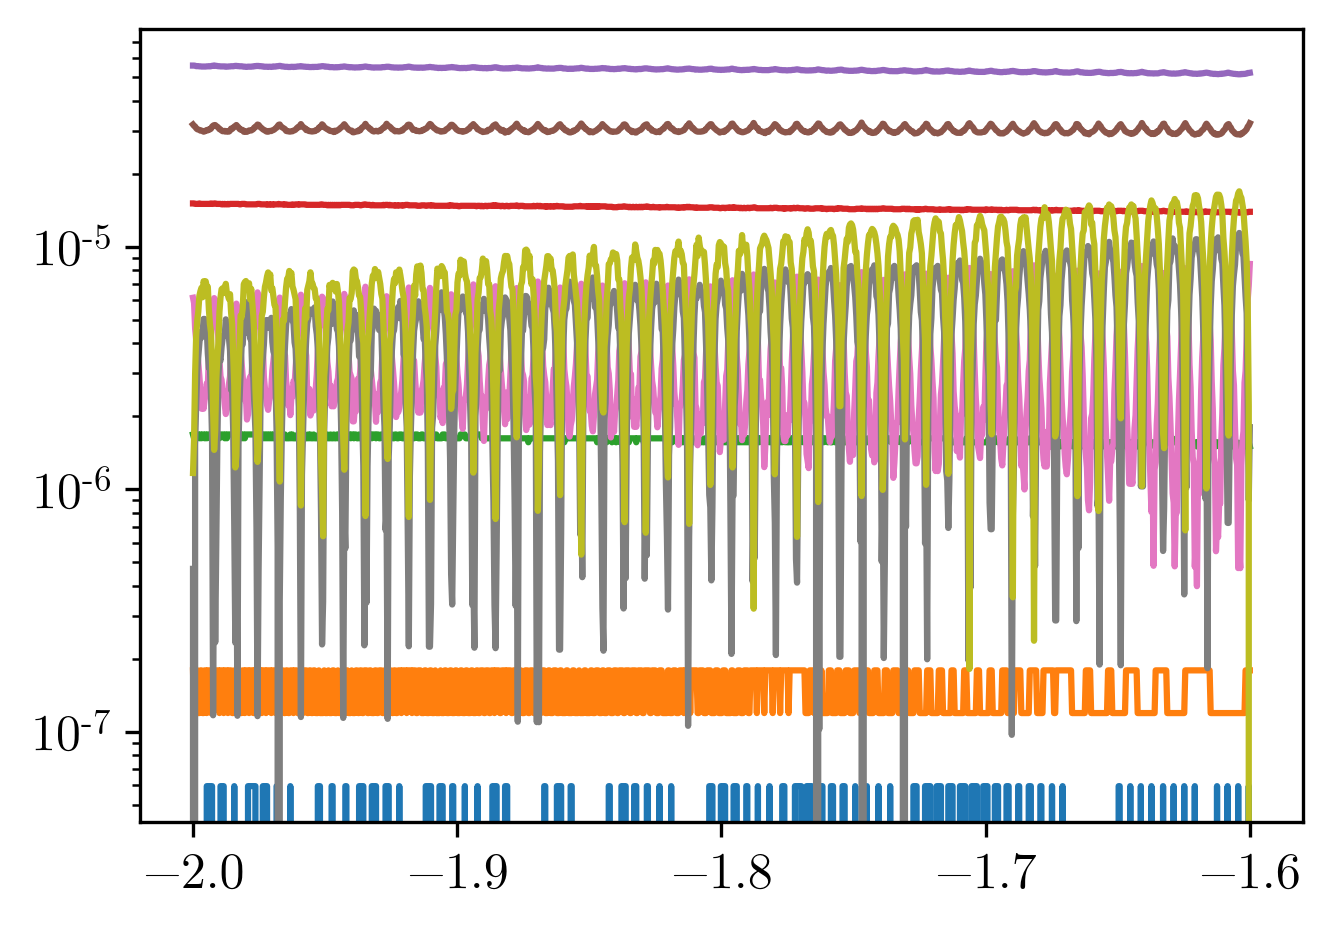

In [211]:
for i, z in enumerate(jnp.geomspace(-1e-4, -1e4, 9)):
    bs = jnp.linspace(1.6, 2.0, 1000)
    vals_scipy = hypgeom_scipy(bs, z)
    vals_jax = jax.vmap(hypgeom_jax, in_axes=(0, None))(bs, z)
    plt.semilogy(-bs, jnp.abs(vals_scipy - vals_jax) / vals_scipy, f"C{i}")

# plt.ylim(0, 1.5)

Interpolating `z`

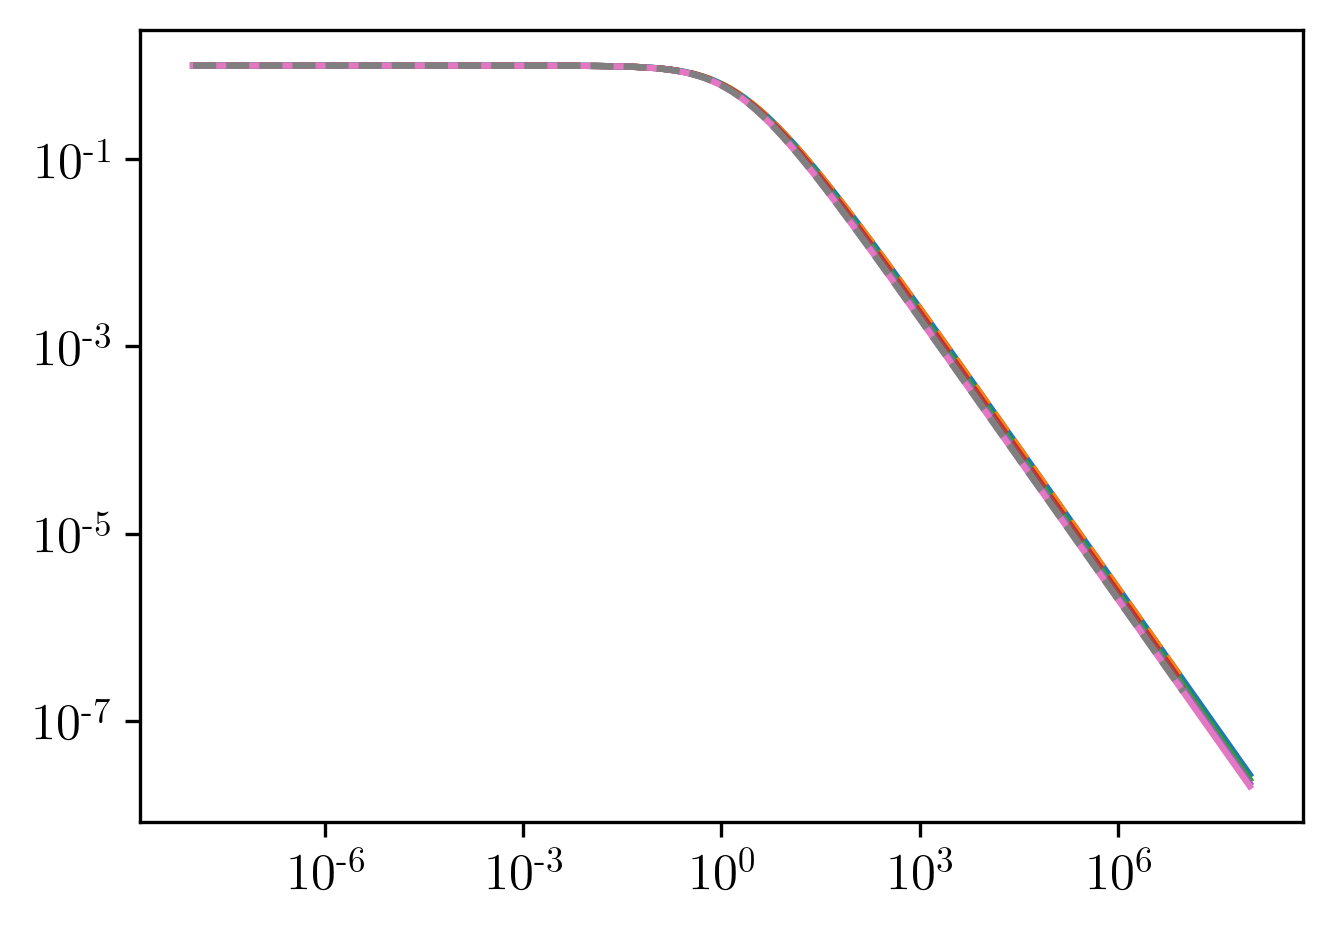

In [212]:
for i, b in enumerate(jnp.linspace(1.6, 2.0, 4)):
    abszs = jnp.geomspace(1e-8, 1e8, 1000)
    vals_scipy = hypgeom_scipy(b, -abszs)
    vals_jax = jax.vmap(hypgeom_jax, in_axes=(None, 0))(b, -abszs)
    plt.loglog(abszs, vals_scipy)
    plt.loglog(abszs, vals_jax, "--")

plt.axhline(0, color="k", linestyle="--", linewidth=0.5)
# plt.ylim(0, 1.5)

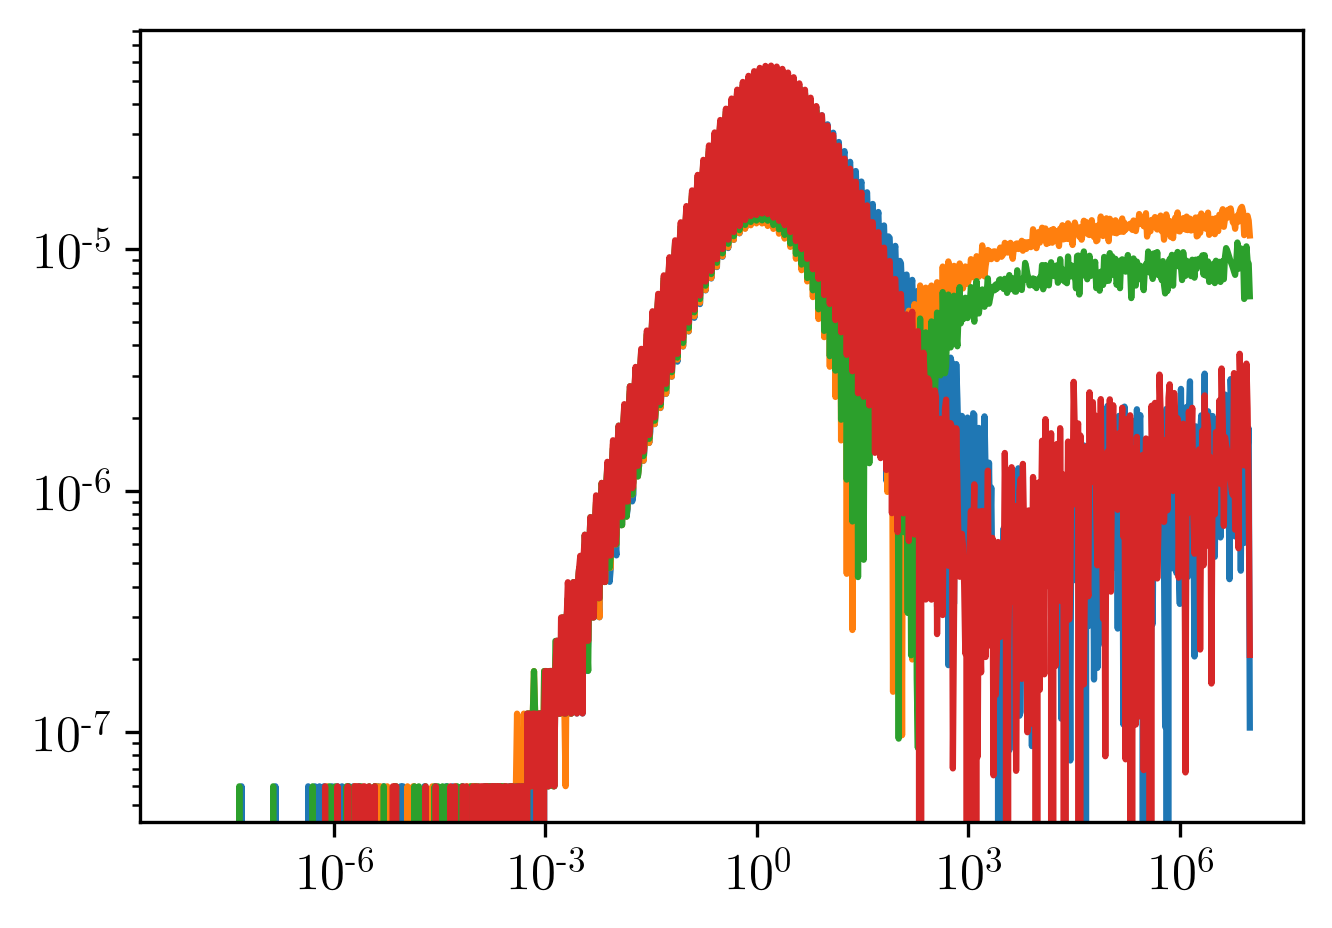

In [213]:
for i, b in enumerate(jnp.linspace(1.6, 2.0, 4)):
    abszs = jnp.geomspace(1e-8, 1e8, 1000)
    vals_scipy = hypgeom_scipy(b, -abszs)
    vals_jax = jax.vmap(hypgeom_jax, in_axes=(None, 0))(b, -abszs)
    plt.loglog(abszs, jnp.abs(vals_scipy - vals_jax) / vals_scipy, f"C{i}")

plt.axhline(0, color="k", linestyle="--", linewidth=0.5)
# plt.ylim(0, 1.5)

### `b < 0`

Interpolating `z`

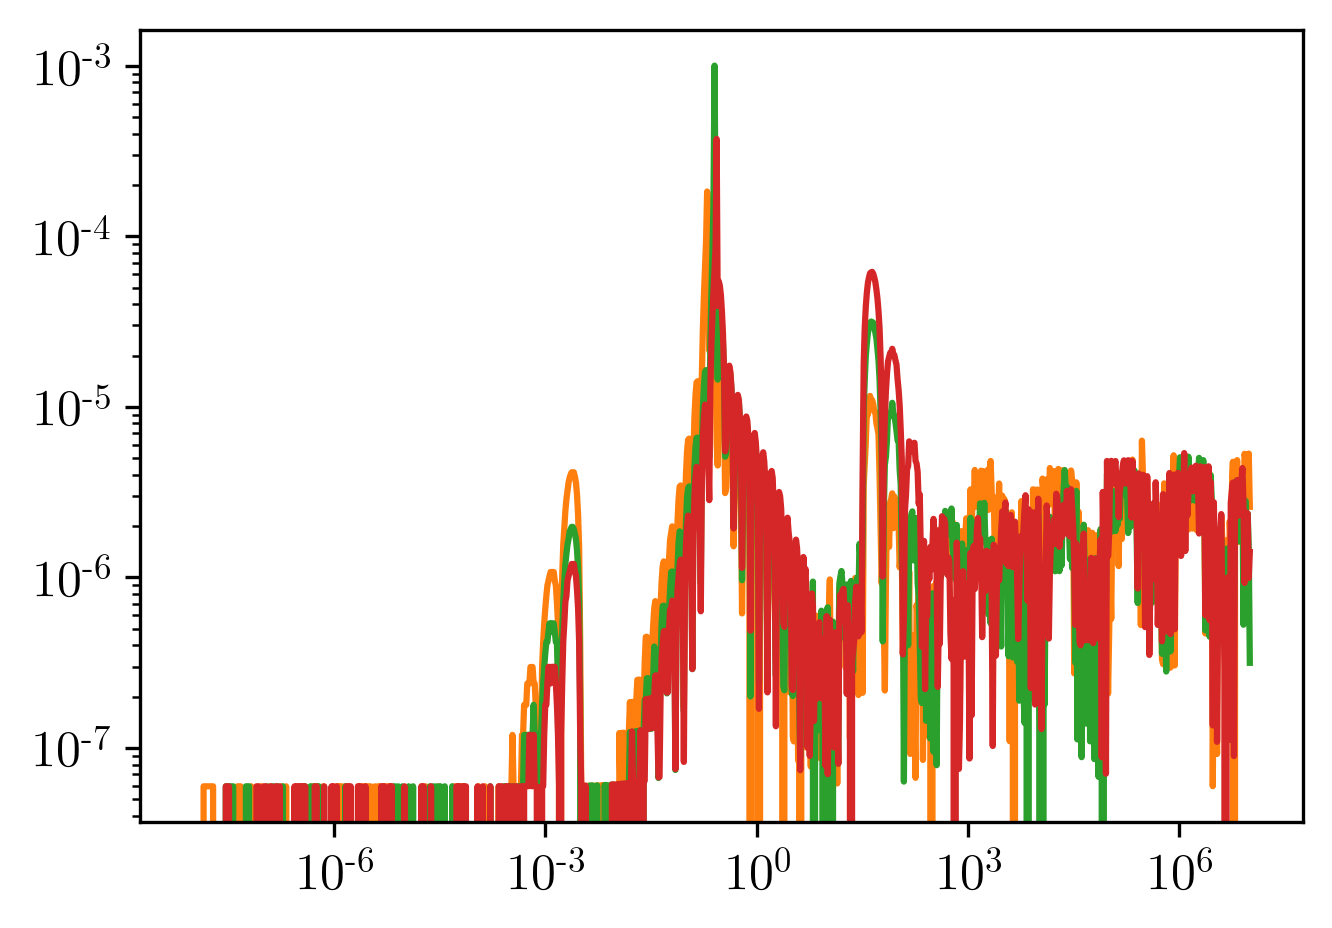

In [214]:
for i, b in enumerate(jnp.linspace(-2.0, -1.6, 4)):
    abszs = jnp.geomspace(1e-8, 1e7, 1000)
    vals_scipy = hypgeom_scipy(b, -abszs)
    vals_jax = jax.vmap(hypgeom_jax, in_axes=(None, 0))(b, -abszs)
    plt.loglog(abszs, jnp.abs(vals_scipy - vals_jax) / jnp.abs(vals_scipy), f"C{i}")

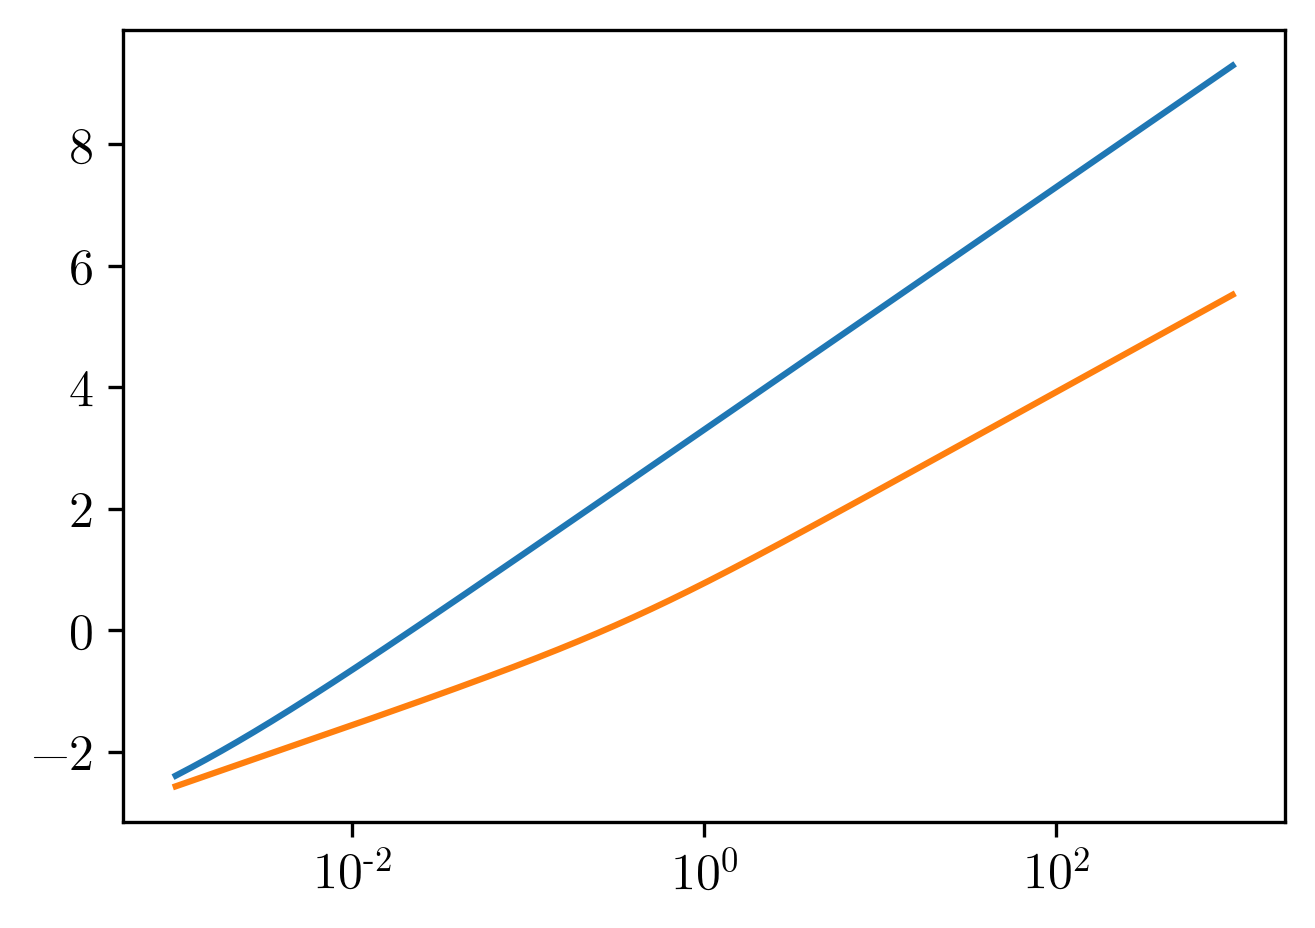

In [215]:
for i, b in enumerate([-1.999, -1.6]):#jnp.linspace(-1.999, -1.6, 4)):
    abszs = jnp.geomspace(10**-3, 10**3, 3000)
    vals_scipy = hypgeom_scipy(b, -abszs)
    vals_jax = jax.vmap(hypgeom_jax, in_axes=(None, 0))(b, -abszs)
#     plt.semilogx(abszs, jnp.log10(1 - vals_scipy))# / jnp.log10(abszs))
#     plt.semilogx(abszs, jnp.log10(1 - vals_jax), "--")# / jnp.log10(abszs), "--")
    plt.semilogx(abszs, jnp.log10(1 - vals_scipy))# / jnp.log10(abszs))

# plt.xlim(10**-0.5, 10**0.5)

Interpolating `b`

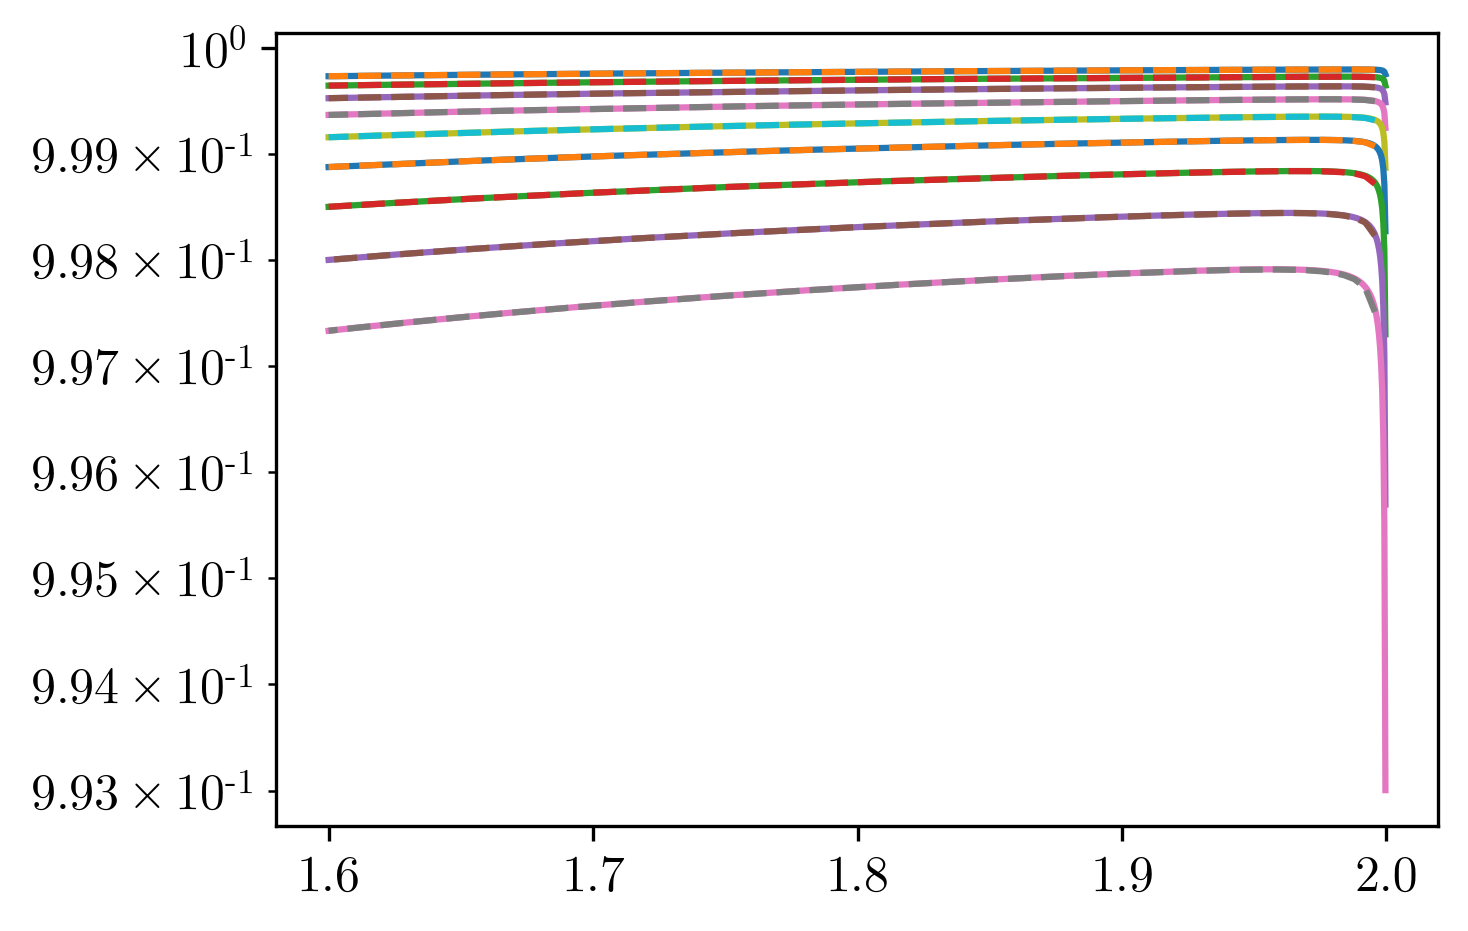

In [216]:
for i, z in enumerate(jnp.geomspace(-1e-4, -1e-3, 9)):
    bs = jnp.linspace(-2.0, -1.6, 1000)
    vals_scipy = hypgeom_scipy(bs, z)
    vals_jax = jax.vmap(hypgeom_jax, in_axes=(0, None))(bs, z)
    plt.semilogy(-bs, vals_scipy)
    plt.semilogy(-bs, vals_jax, "--")

plt.axhline(0, color="k", linestyle="--", linewidth=0.5)
# plt.ylim(0, 1.5)

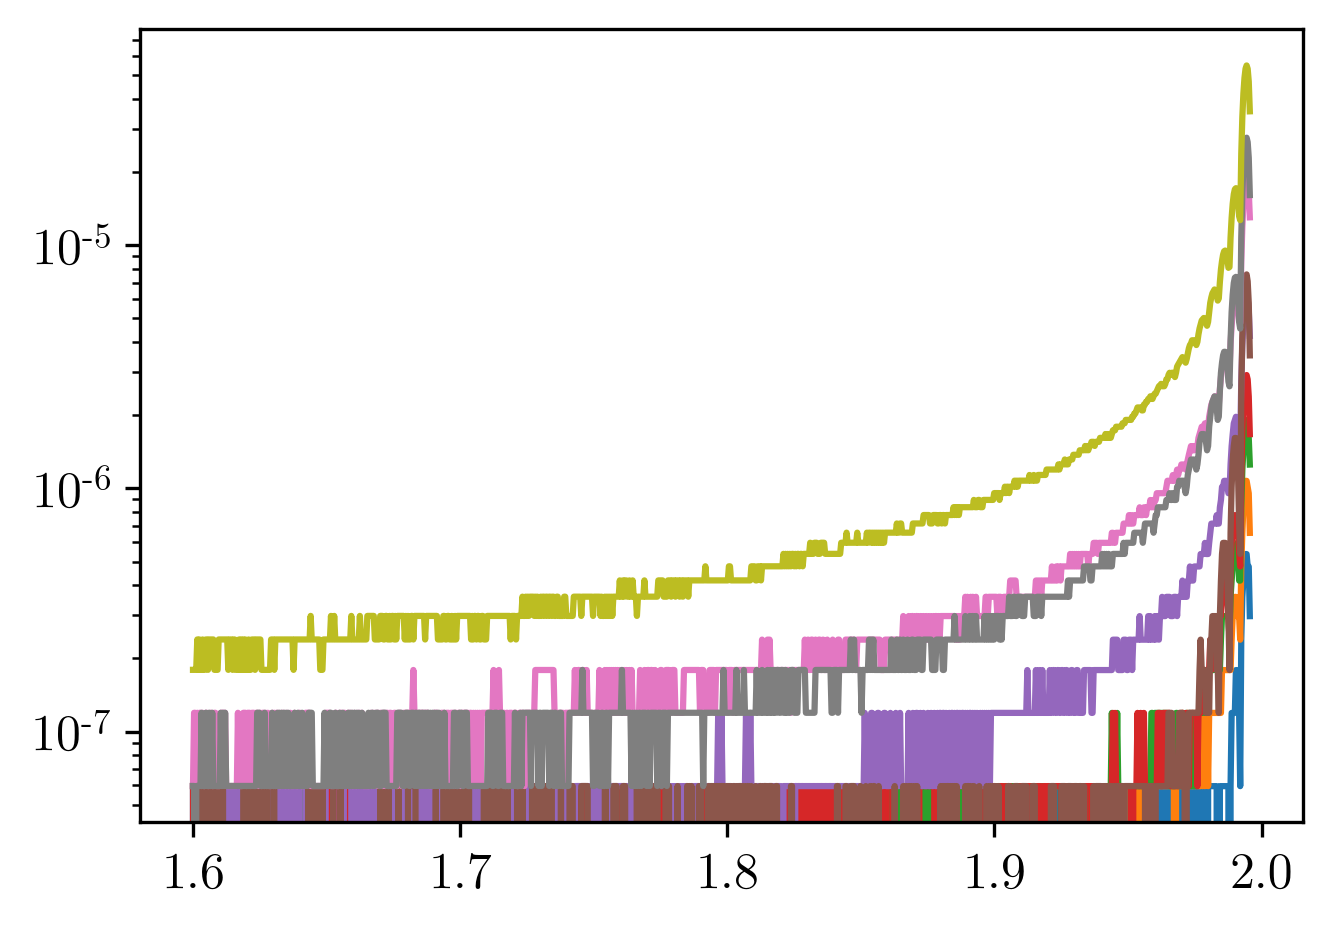

In [217]:
for i, z in enumerate(jnp.geomspace(-1e-4, -1e-3, 9)):
    bs = jnp.linspace(-2.0, -1.6, 1000)
    vals_scipy = hypgeom_scipy(bs, z)
    vals_jax = jax.vmap(hypgeom_jax, in_axes=(0, None))(bs, z)
    plt.semilogy(-bs, jnp.abs(vals_scipy - vals_jax) / vals_scipy, f"C{i}")

plt.axhline(0, color="k", linestyle="--", linewidth=0.5)
# plt.ylim(0, 1.5)

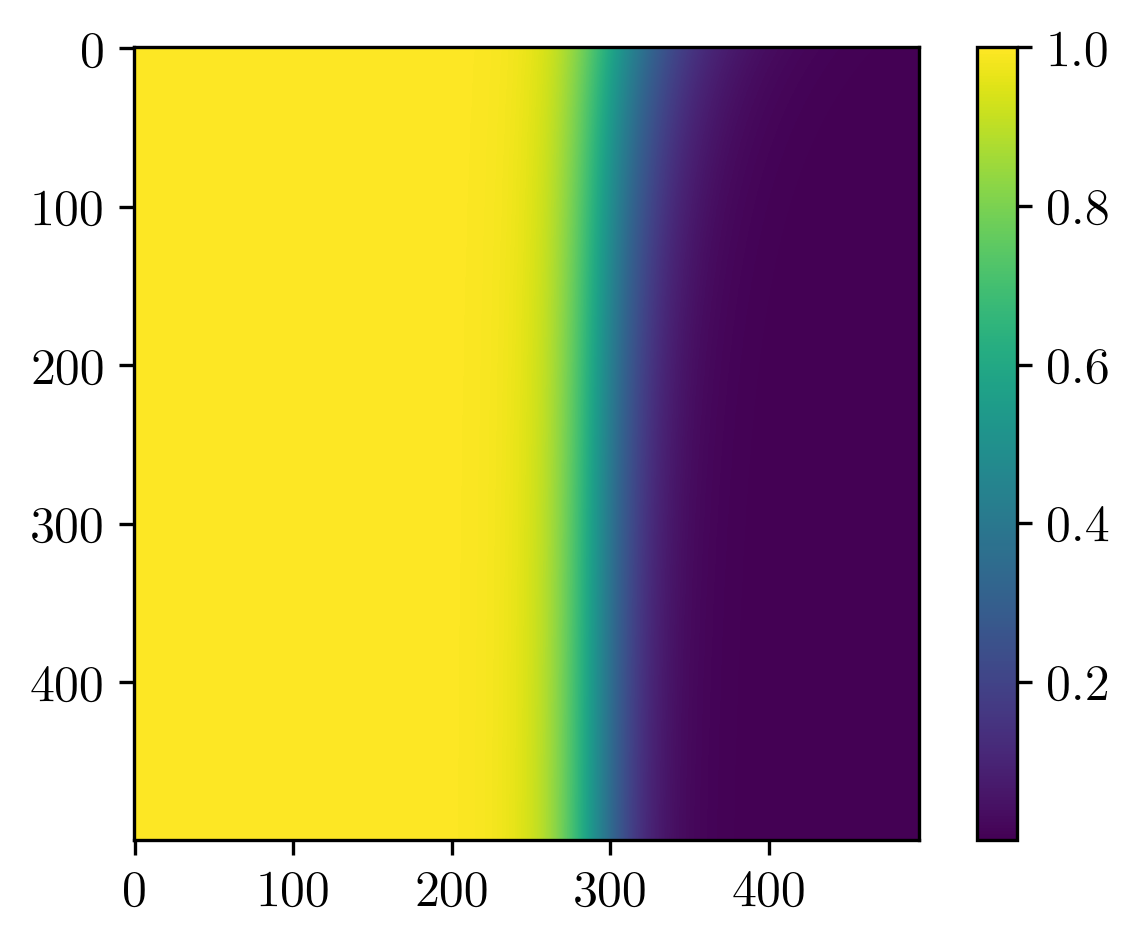

In [52]:
plt.imshow(vals_pos)
plt.colorbar()

In [51]:
b_mg.min().item(), b_mg.max().item()

(0.5, 1.9900000095367432)

In [50]:
z_mg.min().item(), z_mg.max().item()

(-1000000.0, -9.99999993922529e-09)

## Translating `hyp2f1` into jax
I don't think it's possible due to the recursive calls.

In [44]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [ ]:
def switch(index, branches, operand):
    index = clamp(0, index, len(branches) - 1)
    return branches[index](operand)

def fori_loop(lower, upper, body_fun, init_val)
    val = init_val
    for i in range(lower, upper):
        val = body_fun(i, val)
    return val

Scipy implementation of `hyp2f1` ([link](https://github.com/scipy/scipy/blob/main/scipy/special/cephes/hyp2f1.c))
```c
/*                                                      hyp2f1.c
 *  Cases addressed are
 *      Tests and escapes for negative integer a, b, or c
 *      Linear transformation if c - a or c - b negative integer
 *      Special case c = a or c = b
 *      Linear transformation for  x near +1
 *      Transformation for x < -0.5
 *      Psi function expansion if x > 0.5 and c - a - b integer
 *      Conditionally, a recurrence on c to make c-a-b > 0
 *
 *      x < -1  AMS 15.3.7 transformation applied (Travis Oliphant)
 *         valid for b,a,c,(b-a) != integer and (c-a),(c-b) != negative integer
 *
 * x >= 1 is rejected (unless special cases are present)
 *
 * The parameters a, b, c are considered to be integer
 * valued if they are within 1.0e-14 of the nearest integer
 * (1.0e-13 for IEEE arithmetic).
 */

#include "mconf.h"
#include <stdlib.h>
#include "_c99compat.h"

#define EPS 1.0e-13
#define EPS2 1.0e-10

#define ETHRESH 1.0e-12

#define MAX_ITERATIONS 10000

extern double MACHEP;

static double hyt2f1(double a, double b, double c, double x, double *loss);
static double hys2f1(double a, double b, double c, double x, double *loss);
static double hyp2f1ra(double a, double b, double c, double x,
		       double *loss);
static double hyp2f1_neg_c_equal_bc(double a, double b, double x);

double hyp2f1(a, b, c, x)
double a, b, c, x;
{
    double d, d1, d2, e;
    double p, q, r, s, y, ax;
    double ia, ib, ic, id, err;
    double t1;
    int i, aid;
    int neg_int_a = 0, neg_int_b = 0;
    int neg_int_ca_or_cb = 0;

    err = 0.0;
    ax = fabs(x);
    s = 1.0 - x;
    ia = round(a);		/* nearest integer to a */
    ib = round(b);

    if (x == 0.0) {
	return 1.0;
    }

    d = c - a - b;
    id = round(d);

    if ((a == 0 || b == 0) && c != 0) {
	return 1.0;
    }

    if (a <= 0 && fabs(a - ia) < EPS) {	/* a is a negative integer */
	neg_int_a = 1;
    }

    if (b <= 0 && fabs(b - ib) < EPS) {	/* b is a negative integer */
	neg_int_b = 1;
    }

    if (d <= -1 && !(fabs(d - id) > EPS && s < 0)
	&& !(neg_int_a || neg_int_b)) {
	return pow(s, d) * hyp2f1(c - a, c - b, c, x);
    }
    if (d <= 0 && x == 1 && !(neg_int_a || neg_int_b))
	goto hypdiv;

    if (ax < 1.0 || x == -1.0) {
	/* 2F1(a,b;b;x) = (1-x)**(-a) */
	if (fabs(b - c) < EPS) {	/* b = c */
	    if (neg_int_b) {
		    y = hyp2f1_neg_c_equal_bc(a, b, x);
	    } else {
	    	y = pow(s, -a);	/* s to the -a power */
	    }
	    goto hypdon;
	}
	if (fabs(a - c) < EPS) {	/* a = c */
	    y = pow(s, -b);	/* s to the -b power */
	    goto hypdon;
	}
    }



    if (c <= 0.0) {
	ic = round(c);		/* nearest integer to c */
	if (fabs(c - ic) < EPS) {	/* c is a negative integer */
	    /* check if termination before explosion */
	    if (neg_int_a && (ia > ic))
		goto hypok;
	    if (neg_int_b && (ib > ic))
		goto hypok;
	    goto hypdiv;
	}
    }

    if (neg_int_a || neg_int_b)	/* function is a polynomial */
	goto hypok;

    t1 = fabs(b - a);
    if (x < -2.0 && fabs(t1 - round(t1)) > EPS) {
	/* This transform has a pole for b-a integer, and
	 * may produce large cancellation errors for |1/x| close 1
	 */
	p = hyp2f1(a, 1 - c + a, 1 - b + a, 1.0 / x);
	q = hyp2f1(b, 1 - c + b, 1 - a + b, 1.0 / x);
	p *= pow(-x, -a);
	q *= pow(-x, -b);
	t1 = gamma(c);
	s = t1 * gamma(b - a) / (gamma(b) * gamma(c - a));
	y = t1 * gamma(a - b) / (gamma(a) * gamma(c - b));
	return s * p + y * q;
    }
    else if (x < -1.0) {
	if (fabs(a) < fabs(b)) {
	    return pow(s, -a) * hyp2f1(a, c - b, c, x / (x - 1));
	}
	else {
	    return pow(s, -b) * hyp2f1(b, c - a, c, x / (x - 1));
	}
    }

    if (ax > 1.0)		/* series diverges  */
	goto hypdiv;

    p = c - a;
    ia = round(p);		/* nearest integer to c-a */
    if ((ia <= 0.0) && (fabs(p - ia) < EPS))	/* negative int c - a */
	neg_int_ca_or_cb = 1;

    r = c - b;
    ib = round(r);		/* nearest integer to c-b */
    if ((ib <= 0.0) && (fabs(r - ib) < EPS))	/* negative int c - b */
	neg_int_ca_or_cb = 1;

    id = round(d);		/* nearest integer to d */
    q = fabs(d - id);

    /* Thanks to Christian Burger <BURGER@DMRHRZ11.HRZ.Uni-Marburg.DE>
     * for reporting a bug here.  */
    if (fabs(ax - 1.0) < EPS) {	/* |x| == 1.0   */
	if (x > 0.0) {
	    if (neg_int_ca_or_cb) {
		if (d >= 0.0)
		    goto hypf;
		else
		    goto hypdiv;
	    }
	    if (d <= 0.0)
		goto hypdiv;
	    y = gamma(c) * gamma(d) / (gamma(p) * gamma(r));
	    goto hypdon;
	}
	if (d <= -1.0)
	    goto hypdiv;
    }

    /* Conditionally make d > 0 by recurrence on c
     * AMS55 #15.2.07
     */
    if (d < 0.0) {
	/* Try the power series first */
	y = hyt2f1(a, b, c, x, &err);
	if (err < ETHRESH)
	    goto hypdon;
	/* Apply the recurrence if power series fails */
	err = 0.0;
	aid = 2 - id;
	e = c + aid;
	d2 = hyp2f1(a, b, e, x);
	d1 = hyp2f1(a, b, e + 1.0, x);
	q = a + b + 1.0;
	for (i = 0; i < aid; i++) {
	    r = e - 1.0;
	    y = (e * (r - (2.0 * e - q) * x) * d2 +
		 (e - a) * (e - b) * x * d1) / (e * r * s);
	    e = r;
	    d1 = d2;
	    d2 = y;
	}
	goto hypdon;
    }


    if (neg_int_ca_or_cb)
	goto hypf;		/* negative integer c-a or c-b */

  hypok:
    y = hyt2f1(a, b, c, x, &err);


  hypdon:
    if (err > ETHRESH) {
	sf_error("hyp2f1", SF_ERROR_LOSS, NULL);
	/*      printf( "Estimated err = %.2e\n", err ); */
    }
    return (y);

    /* The transformation for c-a or c-b negative integer
     * AMS55 #15.3.3
     */
  hypf:
    y = pow(s, d) * hys2f1(c - a, c - b, c, x, &err);
    goto hypdon;

    /* The alarm exit */
  hypdiv:
    sf_error("hyp2f1", SF_ERROR_OVERFLOW, NULL);
    return NPY_INFINITY;
}






/* Apply transformations for |x| near 1
 * then call the power series
 */
static double hyt2f1(a, b, c, x, loss)
double a, b, c, x;
double *loss;
{
    double p, q, r, s, t, y, w, d, err, err1;
    double ax, id, d1, d2, e, y1;
    int i, aid, sign;

    int ia, ib, neg_int_a = 0, neg_int_b = 0;

    ia = round(a);
    ib = round(b);

    if (a <= 0 && fabs(a - ia) < EPS) {	/* a is a negative integer */
	neg_int_a = 1;
    }

    if (b <= 0 && fabs(b - ib) < EPS) {	/* b is a negative integer */
	neg_int_b = 1;
    }

    err = 0.0;
    s = 1.0 - x;
    if (x < -0.5 && !(neg_int_a || neg_int_b)) {
	if (b > a)
	    y = pow(s, -a) * hys2f1(a, c - b, c, -x / s, &err);

	else
	    y = pow(s, -b) * hys2f1(c - a, b, c, -x / s, &err);

	goto done;
    }

    d = c - a - b;
    id = round(d);		/* nearest integer to d */

    if (x > 0.9 && !(neg_int_a || neg_int_b)) {
	if (fabs(d - id) > EPS) {
	    int sgngam;

	    /* test for integer c-a-b */
	    /* Try the power series first */
	    y = hys2f1(a, b, c, x, &err);
	    if (err < ETHRESH)
		goto done;
	    /* If power series fails, then apply AMS55 #15.3.6 */
	    q = hys2f1(a, b, 1.0 - d, s, &err);
            sign = 1;
            w = lgam_sgn(d, &sgngam);
            sign *= sgngam;
            w -= lgam_sgn(c-a, &sgngam);
            sign *= sgngam;
            w -= lgam_sgn(c-b, &sgngam);
            sign *= sgngam;
	    q *= sign * exp(w);
	    r = pow(s, d) * hys2f1(c - a, c - b, d + 1.0, s, &err1);
            sign = 1;
            w = lgam_sgn(-d, &sgngam);
            sign *= sgngam;
            w -= lgam_sgn(a, &sgngam);
            sign *= sgngam;
            w -= lgam_sgn(b, &sgngam);
            sign *= sgngam;
	    r *= sign * exp(w);
	    y = q + r;

	    q = fabs(q);	/* estimate cancellation error */
	    r = fabs(r);
	    if (q > r)
		r = q;
	    err += err1 + (MACHEP * r) / y;

	    y *= gamma(c);
	    goto done;
	}
	else {
	    /* Psi function expansion, AMS55 #15.3.10, #15.3.11, #15.3.12
	     *
	     * Although AMS55 does not explicitly state it, this expansion fails
	     * for negative integer a or b, since the psi and Gamma functions
	     * involved have poles.
	     */

	    if (id >= 0.0) {
		e = d;
		d1 = d;
		d2 = 0.0;
		aid = id;
	    }
	    else {
		e = -d;
		d1 = 0.0;
		d2 = d;
		aid = -id;
	    }

	    ax = log(s);

	    /* sum for t = 0 */
	    y = psi(1.0) + psi(1.0 + e) - psi(a + d1) - psi(b + d1) - ax;
	    y /= gamma(e + 1.0);

	    p = (a + d1) * (b + d1) * s / gamma(e + 2.0);	/* Poch for t=1 */
	    t = 1.0;
	    do {
		r = psi(1.0 + t) + psi(1.0 + t + e) - psi(a + t + d1)
		    - psi(b + t + d1) - ax;
		q = p * r;
		y += q;
		p *= s * (a + t + d1) / (t + 1.0);
		p *= (b + t + d1) / (t + 1.0 + e);
		t += 1.0;
		if (t > MAX_ITERATIONS) {	/* should never happen */
		    sf_error("hyp2f1", SF_ERROR_SLOW, NULL);
		    *loss = 1.0;
		    return NPY_NAN;
		}
	    }
	    while (y == 0 || fabs(q / y) > EPS);

	    if (id == 0.0) {
		y *= gamma(c) / (gamma(a) * gamma(b));
		goto psidon;
	    }

	    y1 = 1.0;

	    if (aid == 1)
		goto nosum;

	    t = 0.0;
	    p = 1.0;
	    for (i = 1; i < aid; i++) {
		r = 1.0 - e + t;
		p *= s * (a + t + d2) * (b + t + d2) / r;
		t += 1.0;
		p /= t;
		y1 += p;
	    }
	  nosum:
	    p = gamma(c);
	    y1 *= gamma(e) * p / (gamma(a + d1) * gamma(b + d1));

	    y *= p / (gamma(a + d2) * gamma(b + d2));
	    if ((aid & 1) != 0)
		y = -y;

	    q = pow(s, id);	/* s to the id power */
	    if (id > 0.0)
		y *= q;
	    else
		y1 *= q;

	    y += y1;
	  psidon:
	    goto done;
	}

    }

    /* Use defining power series if no special cases */
    y = hys2f1(a, b, c, x, &err);

  done:
    *loss = err;
    return (y);
}





/* Defining power series expansion of Gauss hypergeometric function */

static double hys2f1(a, b, c, x, loss)
double a, b, c, x;
double *loss;			/* estimates loss of significance */
{
    double f, g, h, k, m, s, u, umax;
    int i;
    int ib, intflag = 0;

    if (fabs(b) > fabs(a)) {
        /* Ensure that |a| > |b| ... */
        f = b;
        b = a;
        a = f;
    }

    ib = round(b);

    if (fabs(b - ib) < EPS && ib <= 0 && fabs(b) < fabs(a)) {
        /* .. except when `b` is a smaller negative integer */
        f = b;
        b = a;
        a = f;
        intflag = 1;
    }

    if (
        (fabs(a) > fabs(c) + 1 || intflag)
        && fabs(c - a) > 2
        && fabs(a) > 2
    ) {
        /* |a| >> |c| implies that large cancellation error is to be expected.
         *
         * We try to reduce it with the recurrence relations
         */
        return hyp2f1ra(a, b, c, x, loss);
    }

    i = 0;
    umax = 0.0;
    f = a;
    g = b;
    h = c;
    s = 1.0;
    u = 1.0;
    k = 0.0;
    do {
        if (fabs(h) < EPS) {
            *loss = 1.0;
            return NPY_INFINITY;
        }
        m = k + 1.0;
        u = u * ((f + k) * (g + k) * x / ((h + k) * m));
        s += u;
        k = fabs(u);		/* remember largest term summed */
        if (k > umax)
            umax = k;
        k = m;
        if (++i > MAX_ITERATIONS) {	/* should never happen */
            *loss = 1.0;
            return (s);
        }
    } while (s == 0 || fabs(u / s) > MACHEP);

    /* return estimated relative error */
    *loss = (MACHEP * umax) / fabs(s) + (MACHEP * i);

    return (s);
}


/*
 * Evaluate hypergeometric function by two-term recurrence in `a`.
 *
 * This avoids some of the loss of precision in the strongly alternating
 * hypergeometric series, and can be used to reduce the `a` and `b` parameters
 * to smaller values.
 *
 * AMS55 #15.2.10
 */
static double hyp2f1ra(double a, double b, double c, double x,
		       double *loss)
{
    double f2, f1, f0;
    int n;
    double t, err, da;

    /* Don't cross c or zero */
    if ((c < 0 && a <= c) || (c >= 0 && a >= c)) {
        da = round(a - c);
    }
    else {
        da = round(a);
    }
    t = a - da;

    *loss = 0;

    assert(da != 0);

    if (fabs(da) > MAX_ITERATIONS) {
        /* Too expensive to compute this value, so give up */
        sf_error("hyp2f1", SF_ERROR_NO_RESULT, NULL);
        *loss = 1.0;
        return NPY_NAN;
    }

    if (da < 0) {
        /* Recurse down */
        f2 = 0;
        f1 = hys2f1(t, b, c, x, &err);
        *loss += err;
        f0 = hys2f1(t - 1, b, c, x, &err);
        *loss += err;
        t -= 1;
        for (n = 1; n < -da; ++n) {
            f2 = f1;
            f1 = f0;
            f0 = -(2 * t - c - t * x + b * x) / (c - t) * f1 - t * (x -
                                        1) /
            (c - t) * f2;
            t -= 1;
        }
    } else {
        /* Recurse up */
        f2 = 0;
        f1 = hys2f1(t, b, c, x, &err);
        *loss += err;
        f0 = hys2f1(t + 1, b, c, x, &err);
        *loss += err;
        t += 1;
        for (n = 1; n < da; ++n) {
            f2 = f1;
            f1 = f0;
            f0 = -((2 * t - c - t * x + b * x) * f1 +
               (c - t) * f2) / (t * (x - 1));
            t += 1;
        }
    }

    return f0;
}
```

In [39]:
def _fn(a, c):
    round_cond = jnp.logical_or(
        jnp.logical_and(c < 0, a <= c),
        jnp.logical_and(c >= 0, a >= c)
    )
    da = jax.lax.cond(
        round_cond,
        lambda _: jnp.round(a - c),
        lambda _: jnp.round(a),
        None
    )
    # assert da != 0
    return a - da


def _cond(a, c):
    return (jnp.abs(a) > jnp.abs(c) + )

In [43]:
a = 5.0
c = 2.5
t = _fn(a, c)

DeviceArray(3., dtype=float32, weak_type=True)

In [ ]:
MAX_ITERATIONS = 10000


def hys2f1(a, b, c, x):  # TODO!
    val = 1.0
    loss = 0.0
    return val, loss


def hyp2f1ra(a, b, c, x, loss):
#     double f2, f1, f0;
#     int n;
#     double t, err, da;

    # Don't cross c or zero
    round_cond = jnp.logical_or(
        jnp.logical_and(c < 0, a <= c),
        jnp.logical_and(c >= 0, a >= c)
    )
    da = jax.lax.cond(
        round_cond,
        lambda _: jnp.round(a - c),
        lambda _: jnp.round(a),
        None
    )
    # assert da != 0
    t = a - da
    loss = 0  # TODO: does caller need this back?
    
    def recurse_down(_):  # da < 0
        # Recurse down
        f2 = 0;
        f1 = hys2f1(t, b, c, x, &err);
        *loss += err;
        f0 = hys2f1(t - 1, b, c, x, &err);
        *loss += err;
        t -= 1;
        for (n = 1; n < -da; ++n) {
            f2 = f1;
            f1 = f0;
            f0 = -(2 * t - c - t * x + b * x) / (c - t) * f1 - t * (x - 1) /
                (c - t) * f2;
            t -= 1;
        }

    def recurse_up(_):  # da >= 0
        # Recurse up
        f2 = 0;
        f1 = hys2f1(t, b, c, x, &err);
        *loss += err;
        f0 = hys2f1(t + 1, b, c, x, &err);
        *loss += err;
        t += 1;
        for (n = 1; n < da; ++n) {
            f2 = f1;
            f1 = f0;
            f0 = -((2 * t - c - t * x + b * x) * f1 +
               (c - t) * f2) / (t * (x - 1));
            t += 1;
        }
    
    return jax.lax.cond(
        jnp.abs(da) > MAX_ITERATIONS,
        lambda _: jnp.nan,  # loss = 1; too expensive
        lambda _: jax.lax.cond(
            da < 0,
            recurse_down,
            recurse_up,
            None
        ),
        None
    )

```c
/* 15.4.2 Abramowitz & Stegun. */
static double hyp2f1_neg_c_equal_bc(double a, double b, double x)
{
    double k;
    double collector = 1;
    double sum = 1;
    double collector_max = 1;

    if (!(fabs(b) < 1e5)) {
        return NPY_NAN;
    }

    for (k = 1; k <= -b; k++) {
        collector *= (a + k - 1)*x/k;
        collector_max = fmax(fabs(collector), collector_max);
        sum += collector;
    }

    if (1e-16 * (1 + collector_max/fabs(sum)) > 1e-7) {
        return NPY_NAN;
    }

    return sum;
}
```

In [35]:
from operator import itemgetter

Array = jnp.ndarray


def hyp2f1_neg_c_equal_bc(a: Array, b: Array, x: Array) -> Array:
    def branch_fun(_):
        def body_fun(k, val):
            collector = val["collector"] * (a + k - 1) * x / k
            collector_max = jnp.maximum(collector, val["collector_max"])
            total = val["total"] + val["collector"]
            return {
                "total": total,
                "collector": collector,
                "collector_max": collector_max,
            }

        total, collector_max = itemgetter("total", "collector_max")(
            jax.lax.fori_loop(
                1,
                (-b + 1).astype(int),
                body_fun,
                {"total": 0.0, "collector": 1.0, "collector_max": 1.0},
            )
        )

        return jax.lax.cond(
            1e-16 * (1 + collector_max / jnp.abs(total)) > 1e-7,
            lambda _: jnp.nan,
            lambda _: total,
            None,
        )

    return jax.lax.cond(
        jnp.logical_not(jnp.abs(b) < 1e5), lambda _: jnp.nan, branch_fun, None
    )